### Binary Classification Models

In [1]:
# Import Statements

import sys
import math
import warnings
import joblib
import os
import glob

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn import metrics, svm
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, LocalOutlierFactor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import binarize
from sklearn.covariance import EllipticEnvelope

from imblearn.over_sampling import RandomOverSampler 

warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Initializations

In [2]:
# Box Folder Location containing data files

home_dir = os.path.expanduser('~')

apple_folder_loc = home_dir + "/Library/CloudStorage/Box-Box/Capstone/Capstone/Data Science Capstone/Data"
windows_folder_loc = home_dir + "~/Box/Capstone/Capstone/Data Science Capstone/Data"
linux_folder_loc = ""

data_folder_loc = apple_folder_loc if sys.platform.startswith("darwin") else (windows_folder_loc if sys.platform.startswith("win") else linux_folder_loc)

In [3]:
folder_to_read_for_input_files = "FeatureSelection"
folder_to_save_model = "Models"
random_state = 265
target_level_column = 'ActivationLevel'
reporting_df = pd.DataFrame(columns=['File Name', 'Model', 'Accuracy', 'R-Square', 'Adjusted-R-Square', 'MAE',
                                    'Precision_0', 'Recall_0', 'F1_0', 'Support_0', 'Precision_1', 'Recall_1', 'F1_1', 'Support_1',
                                    'OverTriage_Rate', 'UnderTriage_Rate'])

### Functions to automate

In [4]:
def load_dataset(file_path):
    
    print("\nLoading File {}\n".format(file_path.split("/")[-1]))
    
    data = pd.read_excel(file_path)
    return data

In [5]:
def perform_train_test_split(X, Y, test_size=0.30, random_state=1):
    
    print("Performing {}/{} Train-Test Split".format((1-test_size) * 100, test_size * 100))
    return train_test_split(X, Y, test_size=test_size, random_state=random_state)

In [6]:
def get_classification_report(X_test, y_test, y_pred):
    
    print("\nFinding Classification Report\n")
    
    r_sq = metrics.r2_score(y_pred, y_test)
    adj_r_sq = 1 - (1 - metrics.r2_score(y_test, y_pred)) * ((len(X_test) - 1) / (len(X_test) - X_test.shape[1] - 1))
    
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    report['R-Square'] = r_sq
    report['Adjusted-R-Square'] = adj_r_sq
    
    report['mae'] = mean_absolute_error(y_test, y_pred)
    
    return report

In [7]:
def save_model(model, file_name, model_name):
    
    print("\nSaving model {} \n".format(model_name))
    
    joblib.dump(model, "{}/{}/ModelObjects/{}_{}".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], model_name))

In [8]:
def load_model(model, model_name):
    
    print("\nLoading Model {}\n", model_name)
    
    return joblib.load("{}/{}/ModelObjects/{}".format(data_folder_loc, folder_to_save_model, model_name))

In [9]:
def make_report(X_test, y_test, y_pred, model, model_name, file_name, reporting_df):
    classification_report = get_classification_report(X_test, y_test, y_pred)
    reporting_df = reporting_df.append(
        {
            'File Name': file_name,
            'Model': model_name,
            'Accuracy': classification_report['accuracy'],
            'R-Square': classification_report['R-Square'],
            'Adjusted-R-Square': classification_report['Adjusted-R-Square'],
            'MAE': classification_report['mae'],
            'Precision_0': classification_report['0'].get('precision'),
            'Recall_0': classification_report['0'].get('recall'),
            'F1_0': classification_report['0'].get('f1-score'),
            'Support_0': classification_report['0'].get('support'),
            'Precision_1': classification_report['1'].get('precision'),
            'Recall_1': classification_report['1'].get('recall'),
            'F1_1': classification_report['1'].get('f1-score'),
            'Support_1': classification_report['1'].get('support'),
            'OverTriage_Rate': 1 - float(classification_report['0'].get('recall')),
            'UnderTriage_Rate': 1 - float(classification_report['1'].get('recall'))
        },
        ignore_index=True
    )
    save_model(model, file_name, model_name)
    return reporting_df

In [10]:
def get_model_name(model_name, anomaly_detection):
    return "{}_{}".format(model_name, "AnomalyDetection") if anomaly_detection else model_name

### OverSampling

In [11]:
def perform_oversampling():
    
    print("\nPerforming Oversampling since data labels are distributed as follows:\n")
    data_labels.value_counts()
    
    return RandomOverSampler().fit_resample(data_features, data_labels)

### Stratified Sampling with Cross Validation

In [12]:
def perform_stratified_sampling(X, y, model, n_splits=10, n_repeats=3, n_jobs=-1):
    
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=n_jobs, error_score='raise')

    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

### Bagging Regressor

In [13]:
def perform_bagging(X_train, y_train, X_test, y_test, model, n_estimators, file_name, reporting_df):
    
    print("\nPerforming Bagging Regression\n")
    
    bagging_model = BaggingRegressor(model, n_estimators=n_estimators)
    bagging_model.fit(X_train, y_train)

    test_preds_grid = bagging_model.predict(X_test)
    y_pred = np.round(test_preds_grid).astype(int)
    
    return make_report(X_test, y_test, y_pred, bagging_model, "Bagging Regressor", file_name, reporting_df)

### ROC Curve

In [14]:
def plot_roc_curve(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model):
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)

    # create ROC curve
    plt.plot(fpr, tpr, label=model_name)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig("{}/{}/RocCurves/{}_{}_{}".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], model_name, 'roc_curve.png', dpi=120))
    plt.show()

In [15]:
def plot_precision_recall_curve(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model):
    
    lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, y_pred_prob)
    
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label=model_name)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig("{}/{}/PrecisionRecallCurves/{}_{}_{}".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], model_name, 'precision_recall_curve.png', dpi=120))
    plt.show()

In [16]:
def store_roc_auc_scores_at_different_thresholds(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model):
    
    df = pd.DataFrame(columns=['Threshold', 'ROC-AUC Score', 'Accuracy', 'Recall_1', 'Recall_0', 
                               'Precision_1', 'Precision_0', 'OverTriage_Rate', 'UnderTriage_Rate'])
    
    for threshold in np.arange(0.2, 0.8, 0.025):
        
        y_pred_class = binarize(y_pred_prob.reshape(1, -1), threshold=threshold)[0].astype(int)
        report = metrics.classification_report(y_test, y_pred_class, output_dict=True)
        
        df = df.append({
            'Threshold': threshold,
            'ROC-AUC Score': metrics.roc_auc_score(y_test, y_pred_class),
            'Accuracy': metrics.accuracy_score(y_test, y_pred_class),
            'Recall_1': report['1'].get('recall'),
            'Recall_0': report['0'].get('recall'),
            'Precision_1': report['1'].get('precision'),
            'Precision_0': report['0'].get('precision'),
            'OverTriage_Rate': 1 - float(report['0'].get('recall')),
            'UnderTriage_Rate': 1 - float(report['1'].get('recall'))
        }, 
            ignore_index=True
        )
        
    plt.plot(df['Threshold'], df['Accuracy'] * 100, color='red', label='Accuracy')
    plt.plot(df['Threshold'], df['Recall_1'] * 100, color='blue', label='Recall_1')
    plt.plot(df['Threshold'], df['Recall_0'] * 100, color='purple', label='Recall_0')
    plt.plot(df['Threshold'], df['OverTriage_Rate'] * 100, color='black', label='OverTriage Rate')
    plt.plot(df['Threshold'], df['UnderTriage_Rate'] * 100, color='pink', label='UnderTriage Rate')
    plt.title('Statistics across various thresholds for model - {}'.format(model_name))
    plt.xlabel('Threshold')
    plt.ylabel('Percentage')
    plt.legend()
    plt.savefig("{}/{}/ThresholdGraphs/{}_{}_{}".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], model_name, 'threshold_graph.png', dpi=120))
    plt.show()
    
    return df

In [17]:
def play_with_roc_auc_precision_recall(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model):
    plot_roc_curve(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model)
    plot_precision_recall_curve(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model)
    df = store_roc_auc_scores_at_different_thresholds(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model)
    df.to_excel("{}/{}/Thresholds/{}_{}_ROC_AUC.xlsx".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], model_name))

### Logistic Regression

In [18]:
def perform_logistic_regression(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=False):
    
    print("\nPerforming Logistic Regression\n")
    model_name = get_model_name("LogisticRegression", anomaly_detection)
    
    logreg = LogisticRegression(random_state=random_state)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    play_with_roc_auc_precision_recall(y_test, logreg.predict_proba(X_test)[:,1], model_name, file_name, data_folder_loc, folder_to_save_model)

    logit_model = sm.Logit(data_labels, data_features)
    result = logit_model.fit()
    print("\nSummary for Logit Model:\n\n", result.summary2())

    return make_report(X_test, y_test, y_pred, logreg, model_name, file_name, reporting_df)

### SVM

In [19]:
def perform_svm(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=False):
    
    print("\nPerforming SVM Classification\n")
    model_name = get_model_name("SVM", anomaly_detection)
    
    parameters= {'kernel': ('linear', 'rbf', 'poly'), 'C': [1, 10], 'degree': [2]}
    
    gridsearch = GridSearchCV(svm.SVC(), parameters)
    gridsearch.fit(X_train, y_train)
    
    best_kernel, best_c = gridsearch.best_params_['kernel'], gridsearch.best_params_['C']
    print(gridsearch.best_params_)
#     best_model = svm.SVC(kernel=best_kernel, C=best_c)
    best_model_balanced = svm.SVC(kernel=best_kernel, C=best_c, class_weight='balanced')
    
#     best_model.fit(X_train, y_train)
    best_model_balanced.fit(X_train, y_train)
    
    if best_kernel == 'linear':
        
        print('\nw = ',best_model.coef_)
        print('\nb = ',best_model.intercept_)
        print('\nIndices of support vectors = ', best_model.support_)
        print('\nSupport vectors = ', best_model.support_vectors_)
        print('\nNumber of support vectors for each class = ', best_model.n_support_)
        print('\nCoefficients of the support vector in the decision function = ', np.abs(best_model.dual_coef_))        
    
    elif best_kernel == 'poly':
        best_degree = gridsearch.best_params_['degree']
#         best_model = svm.SVC(kernel=best_kernel, C=best_c, degree=best_degree)
        best_model_balanced = svm.SVC(kernel=best_kernel, C=best_c, degree=best_degree, class_weight='balanced')
#         best_model.fit(X_train, y_train)
        best_model_balanced.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
#     play_with_roc_auc_precision_recall(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model)

#     y_pred = np.round(y_pred_prob).astype(int)
    
#     df = make_report(X_test, y_test, y_pred, best_model, model_name, file_name, reporting_df)
    return make_report(X_test, y_test, best_model_balanced.predict(X_test), best_model_balanced, model_name+'_balanced', file_name, df)

### KNN

#### KNN Regressor

In [20]:
def perform_knn_regressor(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=False):
    
    print("\nPerforming KNN Regression\n")
    model_name = get_model_name("KNNRegressor", anomaly_detection)
    
    parameters = {"n_neighbors": range(1, 50), "weights": ["uniform", "distance"]}
    gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
    gridsearch.fit(X_train, y_train)
    
    best_n_neighbors, best_weight_technique = gridsearch.best_params_['n_neighbors'], gridsearch.best_params_['weights']
    print(gridsearch.best_params_)
    best_model = KNeighborsRegressor(n_neighbors=best_n_neighbors, weights=best_weight_technique)
    best_model.fit(X_train, y_train)

    y_pred_prob = best_model.predict(X_test)
    play_with_roc_auc_precision_recall(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model)

    y_pred = np.round(y_pred_prob).astype(int)
    
    return make_report(X_test, y_test, y_pred, best_model, model_name, file_name, reporting_df)

#### KNN Classifier

In [21]:
def perform_knn_classifier(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=False):
    
    print("\nPerforming KNN Classification\n")
    model_name = get_model_name("KNNClassifier", anomaly_detection)
    
    parameters = {"n_neighbors": range(1, 50), "weights": ["uniform", "distance"]}
    
    gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
    gridsearch.fit(X_train, y_train)

    print("{} Features used during classification: {}".format(gridsearch.n_features_in_, gridsearch.feature_names_in_))

    best_n_neighbors, best_weight_technique = gridsearch.best_params_['n_neighbors'], gridsearch.best_params_['weights']
    print(gridsearch.best_params_)
    best_model = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weight_technique)
    best_model.fit(X_train, y_train)

    y_pred_prob = best_model.predict(X_test)
    play_with_roc_auc_precision_recall(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model)

    y_pred = np.round(y_pred_prob).astype(int)
    
    return make_report(X_test, y_test, y_pred, best_model, model_name, file_name, reporting_df)

### RandomForest

#### Random Forest Regressor

In [22]:
def perform_random_forest_regressor(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, n_estimators=1000):
    
    print("\nPerforming Random Forest Regression\n")
    model_name = "RandomForestRegressor"
    
    rf = RandomForestRegressor(n_estimators = n_estimators, random_state = random_state)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    
    play_with_roc_auc_precision_recall(y_test, predictions, model_name, file_name, data_folder_loc, folder_to_save_model)

    y_pred = np.round(predictions).astype(int)
    
    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

    return make_report(X_test, y_test, y_pred, rf, model_name, file_name, reporting_df)

#### Random Forest Classifier

In [23]:
def perform_random_forest_classifier(data_features, data_labels):
    
    print("\nPerforming Random Forest Classification\n")

    # get a list of models to evaluate
    def get_models():
        models = dict()
        # explore ratios from 10% to 100% in 10% increments
        for i in np.arange(0.1, 1.1, 0.1):
            key = '%.1f' % i
            # set max_samples=None to use 100%
            if i == 1.0:
                i = None
            models[key] = RandomForestClassifier(max_samples=i)
        return models
    
    models = get_models()
    for name, model in models.items():
        print('\n>{}'.format(name))
        perform_stratified_sampling(data_features, data_labels, model)

### Gaussian Naive-Bayes

In [24]:
def perform_gaussian_naive_bayes(X_train, y_train, X_test, y_test, file_name, reporting_df, anomaly_detection=False):
    
    print("\nPerforming Gaussian Naive Bayes\n")
    model_name = get_model_name("GaussianNaiveBayes", anomaly_detection)
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    y_pred = gnb.predict(X_test)
    
    return make_report(X_test, y_test, y_pred, gnb, model_name, file_name, reporting_df)

### Anomaly Detection

#### IsolationForest

In [25]:
def perform_isolation_forest(X_train, contamination):
    
    print("\nPerforming Isolation Forest Anomaly Detection\n")
    
    iso = IsolationForest(contamination=contamination)
    yhat = iso.fit_predict(X_train)
    
    return yhat

#### Elliptic Envelope (Minimum Covariance Determinant) (based upon Gaussian Distribution)

In [26]:
def perform_elliptic_envelope(X_train, contamination):
    
    print("\nPerforming Minimum Covariance Determinant Anomaly Detection\n")
    
    ee = EllipticEnvelope(contamination=contamination)
    yhat = ee.fit_predict(X_train)
    
    return yhat

#### Local Outlier Factor (based upon nearest neighbors)

In [27]:
def perform_local_outlier_factor(X_train, contamination):
    
    print("\nPerforming Local Outlier Factor Anomaly Detection\n")
    
    lof = LocalOutlierFactor(contamination=contamination)
    yhat = lof.fit_predict(X_train)
    
    return yhat

#### One-Class SVM

In [28]:
def perform_one_class_svm(X_train, contamination):
    
    print("\nPerforming One Class SVM Anomaly Detection\n")
    
    ee = svm.OneClassSVM(nu=contamination)
    yhat = ee.fit_predict(X_train)
    
    return yhat

#### Summary

In [29]:
def print_shape_of_updated_train_data_after_anomaly_removal(X_train, y_train, yhat):
    
    # select all rows that are not outliers
    mask = yhat != -1
    X_train, y_train = X_train.iloc[mask, :], y_train[mask]
    
    # summarize the shape of the updated training dataset
    print(X_train.shape, y_train.shape)
    
    return X_train, y_train

In [30]:
def perform_anomaly_detection(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model):
    
    print("\nPerforming Anomaly Detection\n")
    
    contamination = round(y_train.value_counts()[1] / y_train.value_counts().sum(), 2)
    
    yhat = perform_isolation_forest(X_train, contamination)
    X_train, y_train = print_shape_of_updated_train_data_after_anomaly_removal(X_train, y_train, yhat)
    reporting_df = perform_logistic_regression(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=True)
    
    yhat = perform_elliptic_envelope(X_train, contamination)
    X_train, y_train = print_shape_of_updated_train_data_after_anomaly_removal(X_train, y_train, yhat)
    reporting_df = perform_gaussian_naive_bayes(X_train, y_train, X_test, y_test, file_name, reporting_df, anomaly_detection=True)
    
    yhat = perform_local_outlier_factor(X_train, contamination)
    X_train, y_train = print_shape_of_updated_train_data_after_anomaly_removal(X_train, y_train, yhat)
    reporting_df = perform_knn_regressor(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=True)
    reporting_df = perform_knn_classifier(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=True)
        
    yhat = perform_one_class_svm(X_train, contamination)
    X_train, y_train = print_shape_of_updated_train_data_after_anomaly_removal(X_train, y_train, yhat)
    reporting_df = perform_svm(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=True)

    return reporting_df

### T-SNE

In [31]:
def create_tsne(data, target_column_name, data_folder_loc, folder_to_save_model, file_name):
    
    print("\nt-SNE\n")
    
    # That's an impressive list of imports.
    import numpy as np
    from numpy import linalg
    from numpy.linalg import norm
    from scipy.spatial.distance import squareform, pdist

    # We import sklearn.
    import sklearn
    from sklearn.manifold import TSNE
    from sklearn.datasets import load_digits
    from sklearn.preprocessing import scale

    # We'll hack a bit with the t-SNE code in sklearn 0.15.2.
    from sklearn.metrics.pairwise import pairwise_distances
    from sklearn.manifold._t_sne import (_joint_probabilities,
                                        _kl_divergence)
    # from sklearn.utils.extmath import _ravel
    # Random state.
    RS = 20150101

    # We'll use matplotlib for graphics.
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as PathEffects
    import matplotlib
    %matplotlib inline

    # We import seaborn to make nice plots.
    import seaborn as sns
    sns.set_style('darkgrid')
    sns.set_palette('muted')
    sns.set_context("notebook", font_scale=1.5,
                    rc={"lines.linewidth": 2.5})

    # We first reorder the data points according to the handwritten numbers.
    X = np.vstack([data[data[target_column_name]==i].drop([target_column_name], axis=1)
                   for i in range(2)])
    y = np.hstack([data[data[target_column_name]==i][target_column_name]
                   for i in range(2)])

    digits_proj = TSNE(random_state=RS).fit_transform(X)

    def scatter(x, colors):
        # We choose a color palette with seaborn.
        palette = np.array(sns.color_palette("hls", 2))

        # We create a scatter plot.
        f = plt.figure(figsize=(8, 8))
        ax = plt.subplot(aspect='equal')
        sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                        c=palette[colors.astype(np.int)])
        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        ax.axis('off')
        ax.axis('tight')

        # We add the labels for each digit.
        txts = []
        for i in range(2):
            # Position of each label.
            xtext, ytext = np.median(x[colors == i, :], axis=0)
            txt = ax.text(xtext, ytext, str(i), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)

        return f, ax, sc, txts

    scatter(digits_proj, y)
    plt.savefig("{}/{}/tsne/{}_{}".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], 'tsne.png', dpi=120))
    plt.show()

### Read Data Files (xlsx) and run models


Loading File RFE15.xlsx

Performing 70.0/30.0 Train-Test Split

Shape of data: X_train: (7794, 15), y_train: (7794,), X_test: (3341, 15), y_test: (3341,)

Distribution of class labels:
Train:
0    5847
1    1947
Name: ActivationLevel, dtype: int64

Test:
0    2515
1     826
Name: ActivationLevel, dtype: int64


Performing Logistic Regression



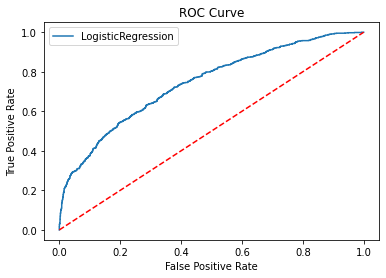

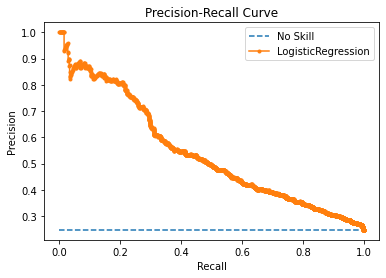

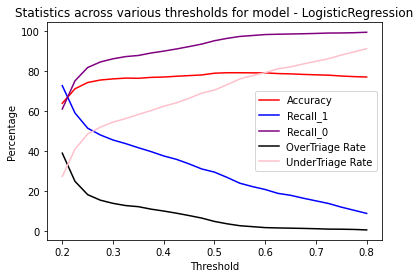

         Current function value: 0.479431
         Iterations: 35

Summary for Logit Model:

                                   Results: Logit
Model:                     Logit                 Pseudo R-squared:      0.146     
Dependent Variable:        ActivationLevel       AIC:                   10706.9322
Date:                      2023-03-13 19:32      BIC:                   10816.6999
No. Observations:          11135                 Log-Likelihood:        -5338.5   
Df Model:                  14                    LL-Null:               -6249.8   
Df Residuals:              11120                 LLR p-value:           0.0000    
Converged:                 0.0000                Scale:                 1.0000    
No. Iterations:            35.0000                                                
----------------------------------------------------------------------------------
                    Coef.    Std.Err.      z     P>|z|      [0.025       0.975]   
---------------------------

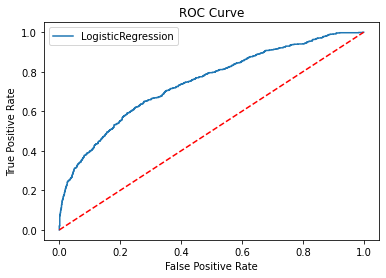

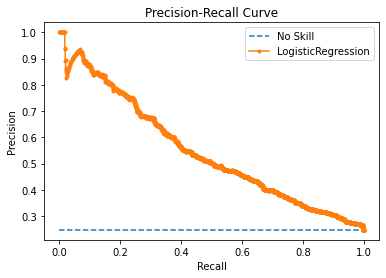

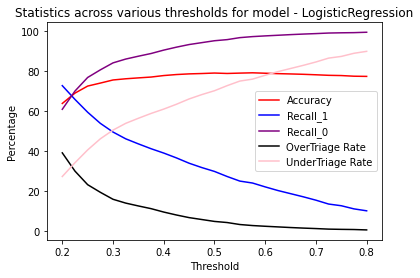

Optimization terminated successfully.
         Current function value: 0.476375
         Iterations 7

Summary for Logit Model:

                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.151     
Dependent Variable:   ActivationLevel  AIC:              10652.8805
Date:                 2023-03-13 19:33 BIC:              10813.8732
No. Observations:     11135            Log-Likelihood:   -5304.4   
Df Model:             21               LL-Null:          -6249.8   
Df Residuals:         11113            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       7.0000                                       
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Age_y                0.4368   0.1052  4.1540 0.0000  0.2307  0.6429
ASSAULT      

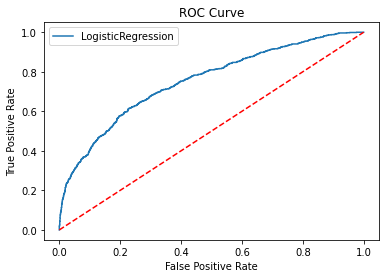

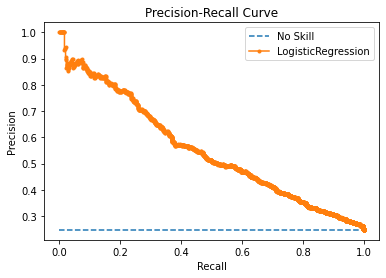

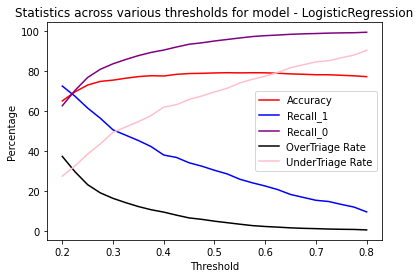

         Current function value: 0.471510
         Iterations: 35

Summary for Logit Model:

                                   Results: Logit
Model:                     Logit                 Pseudo R-squared:      0.160     
Dependent Variable:        ActivationLevel       AIC:                   10552.5307
Date:                      2023-03-13 19:34      BIC:                   10742.7948
No. Observations:          11135                 Log-Likelihood:        -5250.3   
Df Model:                  25                    LL-Null:               -6249.8   
Df Residuals:              11109                 LLR p-value:           0.0000    
Converged:                 0.0000                Scale:                 1.0000    
No. Iterations:            35.0000                                                
----------------------------------------------------------------------------------
                     Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
---------------------------

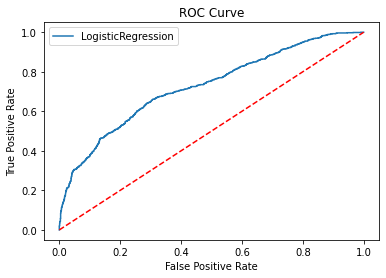

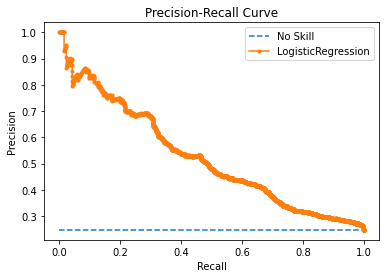

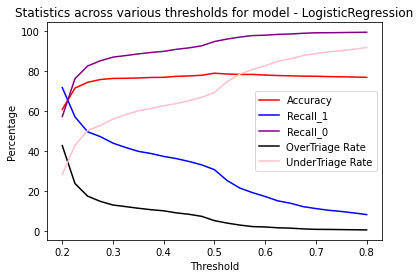

         Current function value: 0.488516
         Iterations: 35

Summary for Logit Model:

                                 Results: Logit
Model:                   Logit                Pseudo R-squared:     0.130     
Dependent Variable:      ActivationLevel      AIC:                  10899.2585
Date:                    2023-03-13 19:35     BIC:                  10972.4370
No. Observations:        11135                Log-Likelihood:       -5439.6   
Df Model:                9                    LL-Null:              -6249.8   
Df Residuals:            11125                LLR p-value:          0.0000    
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                Coef.    Std.Err.      z     P>|z|      [0.025       0.975]   
---------------------------------------------------------------------

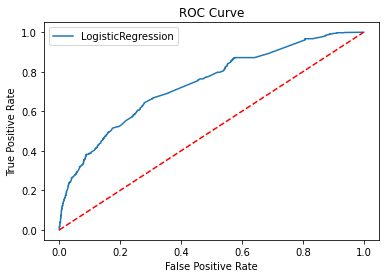

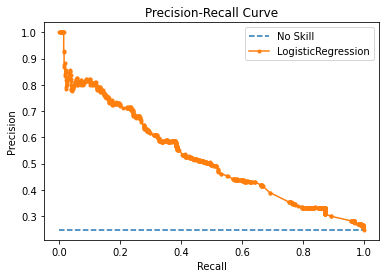

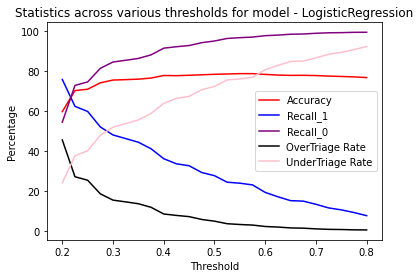

Optimization terminated successfully.
         Current function value: 0.483156
         Iterations 7

Summary for Logit Model:

                            Results: Logit
Model:               Logit             Pseudo R-squared:  0.139     
Dependent Variable:  ActivationLevel   AIC:               10793.8910
Date:                2023-03-13 19:36  BIC:               10918.2944
No. Observations:    11135             Log-Likelihood:    -5379.9   
Df Model:            16                LL-Null:           -6249.8   
Df Residuals:        11118             LLR p-value:       0.0000    
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
PEDS                 0.3848   0.0975   3.9469 0.0001  0.1937  0.5759


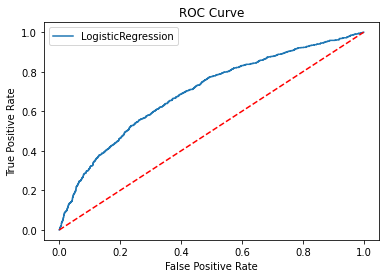

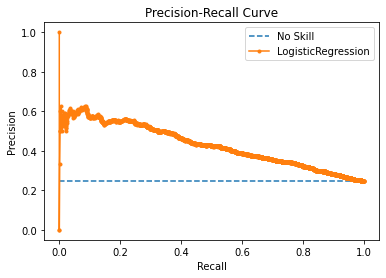

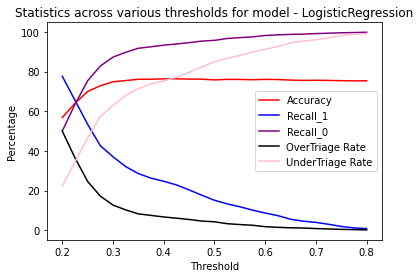

         Current function value: inf
         Iterations: 35

Exception Occured: Singular matrix



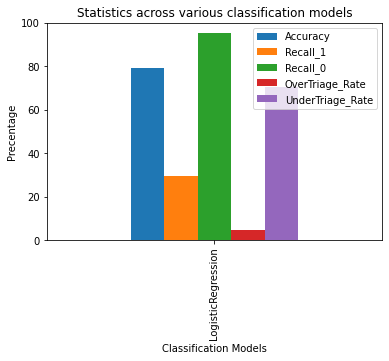

IndexError: index 0 is out of bounds for axis 0 with size 0

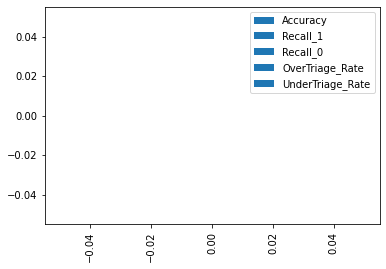

In [32]:
files = glob.glob("{}/{}/*.xlsx".format(data_folder_loc, folder_to_read_for_input_files))

for file_path in files:
    
    try:
        
        # Load Dataset
        file_name = file_path.split("/")[-1]
        data = load_dataset(file_path)
        data_features, data_labels = data.drop(target_level_column, axis=1), data.ActivationLevel
        X_train, X_test, y_train, y_test = perform_train_test_split(data_features, data_labels)
        print("\nShape of data: X_train: {}, y_train: {}, X_test: {}, y_test: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
        print("\nDistribution of class labels:\nTrain:\n{}\n\nTest:\n{}\n".format(y_train.value_counts(), y_test.value_counts()))
        
        # Perform Classification Models
        reporting_df = perform_logistic_regression(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        reporting_df = perform_svm(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        reporting_df = perform_knn_regressor(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        reporting_df = perform_knn_classifier(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        reporting_df = perform_random_forest_regressor(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        perform_random_forest_classifier(data_features, data_labels)
        reporting_df = perform_gaussian_naive_bayes(X_train, y_train, X_test, y_test, file_name, reporting_df)
        
        # Perform Anomaly Detection
        reporting_df = perform_anomaly_detection(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        
        # Show t-SNE cluster image
        create_tsne(data, target_level_column, data_folder_loc, folder_to_save_model, file_name)
    
    except Exception as e:
        print("\nException Occured: {}\n".format(e))
            
reporting_df
reporting_df.to_excel("{}/{}/{}".format(data_folder_loc, folder_to_save_model, 'ModelOutput.xlsx'), index=False)

for file_path in files:
    
    file_name = file_path.split("/")[-1]
    df = reporting_df[reporting_df['File Name'] == file_name]
    
    df['Accuracy'] = df['Accuracy'] * 100
    df['Recall_1'] = df['Recall_1'] * 100
    df['Recall_0'] = df['Recall_0'] * 100
    df['OverTriage_Rate'] = df['OverTriage_Rate'] * 100
    df['UnderTriage_Rate'] = df['UnderTriage_Rate'] * 100
    
    df.reset_index().plot(
        x="Model", y=["Accuracy", "Recall_1", "Recall_0", "OverTriage_Rate", "UnderTriage_Rate"], kind="bar"
    )
    
    plt.title("Statistics across various classification models")
    plt.xlabel("Classification Models")
    plt.ylabel("Precentage")
    plt.legend()
    plt.savefig("{}/{}/ModelOutputGraphs/{}_{}".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], 'models.png', dpi=120))
    plt.show()
